{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Subtract Raster Data in Open Source Python 

After completing this tutorial, you will be able to:
* Derive a **Canopy Height Model** in `Python` using a Digital Elevation Model and a Digital Surface Model derived from Lidar data. 
* Subtract one raster layer from another using raster math and open source Python.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and a working version of python version 3.x.

{% include/data_subsets/course_earth_analytics/_data-colorado-flood.md %}

</div>

Often you need to process two raster datasets together to create a new raster output and then save 
that output as a new file. In this lesson, you will learn how to subtract rasters and create a new 
GeoTIFF file in open source **Python** using **rioxarray** which is a wrapper package that adds 
additional spatial functions to **xarray**.

Begin by importing the necessary packages, downloading data, and setting the working directory.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Open and plot the lidar digital elevation model (DEM). Note that when you read the data, you can use the argument `masked = True` to ensure that the no data values do not plot and are assigned `nan` or `nodata`. 

<!-- 
If we use masked=True we can skip this step
# Insert nans
#lidar_dem_im[lidar_dem_im == lidar_dem.nodata] = np.nan
-->

In [2]:
# Define relative path to file
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open lidar dem
lidar_dem_xr = rxr.open_rasterio(lidar_dem_path, masked=True).squeeze()
lidar_dem_xr

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

### Import Digital Surface Model (DSM)

Next, you will open the digital surface model (DSM). The DSM represents the top of
the earth's surface. Thus, it includes trees, buildings and other objects that
sit on the earth.

In [3]:
# Define relative path to file
lidar_dsm_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DSM.tif")

# Open lidar dem
lidar_dsm_xr = rxr.open_rasterio(lidar_dsm_path, masked=True).squeeze()
lidar_dsm_xr

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref


## Canopy Height Model

The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it's the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded). 

Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly cleaned before assuming it represents all trees!

### Calculate difference between two rasters

There are different ways to calculate a CHM. One easy way is to subtract the
DEM from the DSM.

**DSM - DEM = CHM**

This math gives you the residual value or difference between the top of the
earth surface and the ground which should be the heights of the trees (and buildings
if the data haven't been "cleaned").

<i class="fa fa-star"></i> **Data Tip:** Note that this method of subtracting 2 rasters to create a CHM may not give you the most accurate results! There are better ways to create CHM's using the point clouds themselves. However, in this lesson you learn this method as a means to get more familiar with the CHM dataset and to understand how to perform raster calculations in `Python`. 
{: .notice--success}

Before you subtract the two rasters.
Before performing this calculate however you should check to ensure that they cover the same 
spatial extent and are of the same spatial resolution (pixel size).

In [4]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      lidar_dem_xr.rio.bounds() == lidar_dsm_xr.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      lidar_dem_xr.rio.resolution() == lidar_dsm_xr.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


It looks like the bounds and resolution are the same. This means it is safe for you to subtract the two rasters without significant errors or uncertainty introduced. 

Below you calculate the difference between the two arrays to generate a 
Canopy Height Model. You then plot your newly created canopy height model.

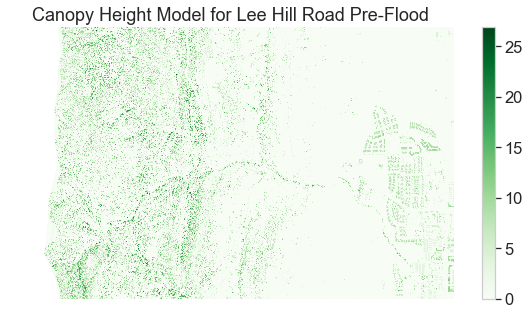

In [6]:
# Calculate canopy height model
lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr

# Plot the data
f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_xr.plot(cmap="Greens")
ax.set(title="Canopy Height Model for Lee Hill Road Pre-Flood")
ax.set_axis_off()
plt.show()

Plot a histogram to explore the range of raster values in your newly created CHM data.

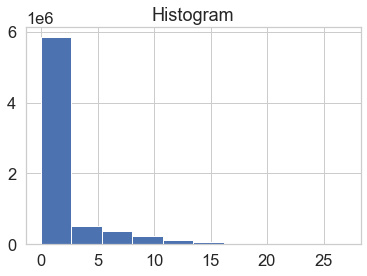

In [17]:
lidar_chm_xr.plot.hist()
plt.show()

Take a close look at the CHM plot. Do you think that the data just represents trees? Or do you see anything that may suggest that there are other types of objects represented in the data?


### Explore the CHM Data

Next, explore the data values in your CHM. Think about the values representing things like trees and buildings in your data.

Do the data make sense?

In [7]:
print('CHM minimum value: ', np.nanmin(lidar_chm_xr))
print('CHM max value: ', np.nanmax(lidar_chm_xr))

CHM minimum value:  0.0
CHM max value:  26.9300537109375


## Export a Raster to Geotiff Using RioXarray

You can export a raster file in `python` using the `rioxarray` `write()` function. 
Export the canopy height model that you just created to your data folder. You will 
create a new directory called "outputs" within the `colorado-flood` directory. This 
structure allows you to keep things organized, separating your outputs from the data 
you downloaded.

NOTE: you can use the code below to check for and create an outputs directory. OR, you can create the directory yourself using the finder (MAC) or windows
explorer.

In [8]:
data_path = os.path.join("colorado-flood",
                         "spatial",
                         "outputs")

if os.path.exists(data_path):
    print("The directory", data_path, "exists!")
else:
    os.makedirs(data_path)

The directory colorado-flood/spatial/outputs exists!


### Exporting Numpy Arrays to Geotiffs

Next, you need to consider the metdata associated with your chm. Remember that the chm was generated using 2 numpy arrays. Neither of these arrays has spatial data directly associated with it. BUT you do have the rasterio object that has metadata that you can use if you want to assign all of the spatial attributes that are needed to save a usable geotiff file.

You can use the syntax

`**dictionary-metadata-object-here` 

to apply all of the spatial attributes from one of your raster objects, when you write out your new chm raster.

To begin, have a look at the lidar_dem metadata dictionary. Looking at the example below, all of the metadata in that dictionary are the same as what we expect the output chm to have. Thus we can use the metadata as they are. 

In [9]:
# Make sure that your output data has a crs & no data value defined
print("The crs is", lidar_chm_xr.rio.crs)
print("The no data value is", lidar_chm_xr.rio.nodata)

The crs is EPSG:32613
The no data value is None


Create the path to a new tif file.

In [10]:
pre_chm_data_path = os.path.join(data_path, "pre-flood-chm.tif")
pre_chm_data_path

'colorado-flood/spatial/outputs/pre-flood-chm.tif'

Export the data to a geotiff format. 

In [11]:
# Export data to geotiff
lidar_chm_xr.rio.to_raster(pre_chm_data_path)

In [12]:
# Reopen the data
lidar_chm_data = rxr.open_rasterio(pre_chm_data_path, masked=True).squeeze()
lidar_chm_data

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [13]:
# # Write the no data value
# with xr.open_rasterio(pre_chm_data_path) as src_rio:
#     chm_xr = src_rio.rio.write_crs(lidar_dsm_xr.rio.nodata, inplace=True)

# with xr.open_dataset(full_file_path) as file_nc:
#     climate_data_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Optional Challenge

Practice your skills. Open the lidar_chm GeoTIFF file that you just created. 
Do the following:

1. View the crs - is it correct?
2. View the x and y spatial resolution. 
3. Plot the data using a color bar of your choice. 

Your plot should look like the one below (athough the colors may be different.
</div>

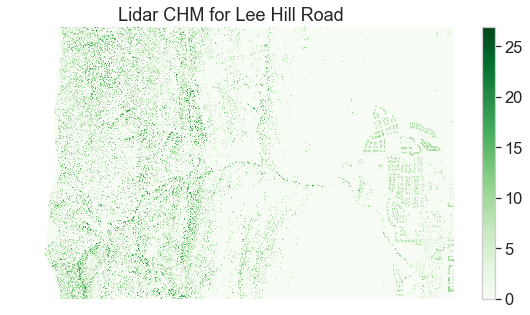

In [14]:
# Import the data
lidar_chm_data = rxr.open_rasterio(pre_chm_data_path, masked=True).squeeze()

f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_data.plot(cmap='Greens')
ax.set(title="Lidar CHM for Lee Hill Road")
ax.set_axis_off()
plt.show()

<div class="notice--success" markdown="1">

<i class="fa fa-star" aria-hidden="true"></i> **Data Tip:** You can simplify the directory code above by using the exclamation `not` which tells Python to return the INVERSE or opposite of the function you have requested Python to run.

</div>